**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.**

In [1]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
!{sys.executable} -m pip install skorch

     |████████████████████████████████| 122kB 2.8MB/s 


In [0]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import numpy as np
from PIL import Image
from torchvision import models
from torchvision import transforms
from skorch import NeuralNetClassifier, NeuralNet
import torch

In [3]:
#@title -- Downloading Data -- { display-mode: "form" }
!mkdir -p data
!mkdir -p output
!wget -nc -O data/cat.jpg https://www.dropbox.com/s/a5ux951zo01gd5z/cat.jpg?dl=1
!wget -nc -O data/imagenet_classes https://www.dropbox.com/s/ma25i7w3jpqex2a/imagenet_classes?dl=1

--2020-05-14 17:21:25--  https://www.dropbox.com/s/a5ux951zo01gd5z/cat.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/a5ux951zo01gd5z/cat.jpg [following]
--2020-05-14 17:21:26--  https://www.dropbox.com/s/dl/a5ux951zo01gd5z/cat.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce384724c6194a4512aa067fb97.dl.dropboxusercontent.com/cd/0/get/A3v944DXun2DildbrWLwvT2F2-w6wreS7MvVlQps_YRDL2Vu4YKHpwTaIH0ID0tmHxE30JncAMY-PmJc4wCifPxYMndito1l5qMerDSEv8ru2GDL_W9d5UqpPim-I3A9Yfk/file?dl=1# [following]
--2020-05-14 17:21:26--  https://uce384724c6194a4512aa067fb97.dl.dropboxusercontent.com/cd/0/get/A3v944DXun2DildbrWLwvT2F2-w6wreS7MvVlQps_YRDL2Vu4YKHpwTaIH0ID0tmHxE30JncAMY-PmJc4wCifPxYMndito1l5qMerDSEv8ru2GDL_W9d5UqpPim-

In [0]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
with open("data/imagenet_classes", "r") as file:
    classes = [c[:-1] for c in file.readlines()]
    
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def preproc_image(img):
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    return batch_t

# Using a Pre-trained Classifier

This notebook will show a very simple example of loading and using a classifier pre-trained on ImageNet. We will show how it can be used to classify new images.
# Loading the Model

In the previous examples we have defined a class for our own neural net and specified its architecture. Now we will instead use one of the predefined models with pretrained weights. These models are available in the ``torchvision.models`` package. We will use architecture ``densenet169`` in particular and specify the argument ``pretrained=True`` when creating an instance. This means that the network is to be initialized with weights pretrained on the ImageNet dataset. If we are calling this piece of code for the first time, the weight will need to be downloaded over the internet first.

To load a model we could also use the ``torch.hub`` tool – in that case the model would not have to be built into PyTorch. We could instead load it directly from one of the special GitHub repositories that support this. For instance, we could load the well-known EfficientNetB0 using the following code:
```python
torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b0', pretrained=True)
```

In [5]:
module = models.densenet169(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth


When creating a classifier we will now only need to specify the instance of our model and specify the device that we want to use. In our case we will, however, need to append a softmax layer to the end of the network – networks from ``torchvision.models`` do not have a softmax layer because the loss function they were trained incorporated it. We are not going to train the model and therefore we also need to call function ``initialize``, which will make the network ready for inference (the pretrained weights will of course not be replaced).

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

net = NeuralNetClassifier(
    torch.nn.Sequential(module, torch.nn.Softmax()),
    device=device,
)

net.initialize();

## Using the Model

We load and preprocess the image that we want to classify.

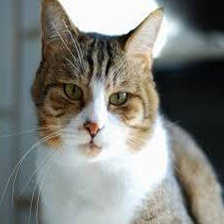

In [7]:
img = Image.open("data/cat.jpg")
display(img)

Before plugging the image into the network we will need to apply some slight preprocessing using function ``preproc_image``. This is because we need to ensure that images are preprocessed in the same way as when the network was trained.

In [8]:
img_prep = preproc_image(img)
y = net.predict(img_prep)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


The network will return the number of the class. The list of class labels is stored in the ``classes`` list (it was read from a file in the auxiliary code section), so we only need to index it using the output of our network:

In [9]:
classes[y.item()]

'tabby'

## Displaying the Top-5 Predictions

Given that our network actually predicts class probabilities, we might want to known about those and not just about the label of the most probable class. In fact, let's display the top-5 predictions and their probabilities. This will give us a better idea of how confident the neural network is about its prediction and whether the other, less probable predictions make any sense or not.

Our neural classifier has an interface for querying about probabilities: we can use the ``predict_proba`` method, which is also available in a number of different ``scikit-learn`` classifiers.

In [11]:
proba = net.predict_proba(img_prep)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Once we have got the probabilities, all we need to do is to sort them and identify the classes with the top-5 probabilities. To this end we will define a small auxiliary function and apply it to the probabilities.

In [0]:
def decode_proba(proba, top=5):
    proba = proba.ravel()
    ind = np.argsort(proba)
    
    for c in reversed(ind[-top:]):
        print("{}:\t{} ({})".format(
            np.array2string(proba[c], precision=5),
            classes[c], c))

In [13]:
decode_proba(proba)

0.59942:	tabby (281)
0.17429:	tiger_cat (282)
0.16293:	Egyptian_cat (285)
0.03827:	lynx (287)
0.0012:	plastic_bag (728)


---

## Task 1: Predictions about Other Images

**Try to apply the same procedure to a different image.**

Note: New images can be uploaded **directly through the notebook interface** or else using:
```python
from google.colab import files
content_img = files.upload()
filename = list(content_img)[0]
```

---

Saving carbonara1.jpg to carbonara1.jpg


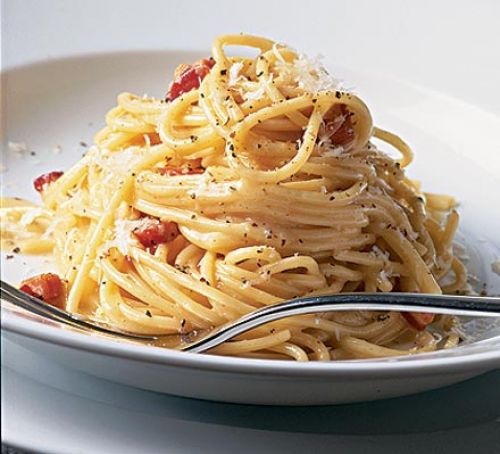

0.99998:	carbonara (959)
1.43996e-05:	broccoli (937)
2.308e-06:	spaghetti_squash (940)
1.46044e-06:	plate (923)
2.82956e-07:	soup_bowl (809)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [21]:
from google.colab import files
files.upload()

img = Image.open("carbonara1.jpg")
display(img)

img_prep = preproc_image(img)
y = net.predict(img_prep)

proba = net.predict_proba(img_prep)
decode_proba(proba)




The list of classes that the network is supposed to be able to classify can be found in file ``data/imagenet_classes``

In [14]:
for ic, c in enumerate(classes):
    print("{}:\t{}".format(ic, c))

0:	tench
1:	goldfish
2:	great_white_shark
3:	tiger_shark
4:	hammerhead
5:	electric_ray
6:	stingray
7:	cock
8:	hen
9:	ostrich
10:	brambling
11:	goldfinch
12:	house_finch
13:	junco
14:	indigo_bunting
15:	robin
16:	bulbul
17:	jay
18:	magpie
19:	chickadee
20:	water_ouzel
21:	kite
22:	bald_eagle
23:	vulture
24:	great_grey_owl
25:	European_fire_salamander
26:	common_newt
27:	eft
28:	spotted_salamander
29:	axolotl
30:	bullfrog
31:	tree_frog
32:	tailed_frog
33:	loggerhead
34:	leatherback_turtle
35:	mud_turtle
36:	terrapin
37:	box_turtle
38:	banded_gecko
39:	common_iguana
40:	American_chameleon
41:	whiptail
42:	agama
43:	frilled_lizard
44:	alligator_lizard
45:	Gila_monster
46:	green_lizard
47:	African_chameleon
48:	Komodo_dragon
49:	African_crocodile
50:	American_alligator
51:	triceratops
52:	thunder_snake
53:	ringneck_snake
54:	hognose_snake
55:	green_snake
56:	king_snake
57:	garter_snake
58:	water_snake
59:	vine_snake
60:	night_snake
61:	boa_constrictor
62:	rock_python
63:	Indian_cobra
64:	gr